<a href="https://colab.research.google.com/github/titilomt/data_science_puc_projects/blob/master/Aula_4_CDBD_08_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!python -m spacy download pt
!python -m spacy download en
!pip install spacy
!pip install beautifulsoup4

     |████████████████████████████████| 21.2MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186282 sha256=26cbdc3fc356d5c6bfe9e9e2a90123bd33e47af64997c45f3e385db3c3cbf2db
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pg04pop/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
import nltk
import spacy
from spacy import displacy 
import tqdm
import operator
import requests
from bs4 import BeautifulSoup
import re
import pt_core_news_sm
import en_core_web_sm
from collections import Counter
import random
import operator
import matplotlib.pyplot as plt

# Pos tagging

## Abordagem Manual

Em empresas, quando queremos construir/usar um POS Tagging, estamos buscando uma ferramenta para trabalhar em algum cenário específico e direcionado ao negócio. Por exemplo, recuperar todos os verbos de um texto, para analisar de forma geral as ações que um cliente conecta com a marca no Twitter. Nesse sentido, podemos usar duas abordagens:

    1 - Construir um modelo próprio que resolva esse cenário
    2 - Usar modelos que já existem e, se necessário, treiná-los para melhor performance no nosso cenário

Para esse exercício, vamos simular esse cenário de recuperar verbos de um texto. Apesar da abordagem 2 parecer mais interessante, vamos tentar construir nosso próprio modelo e aprender um pouco sobre a complexidade do problema.

Inicialmente, vamos reduzir bem nosso escopo, focando em

    - REGEX com NamedGoups
    - Verbos simples, como estudar
    
Use o método abaixo para verificar quais grupos foram identificados pela expressão regular:

```python
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})
```

Mais informações de regex: https://docs.python.org/pt-br/3.8/howto/regex.html

In [ ]:
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})

In [ ]:
phrase1 = "eu estudo, você estuda, nós estudamos e vc sabe como é... estudos em todo lugar "

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w?\b)'

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}


<b> Atividade </b>

1) Modifique o padrão da regex para conseguir reconhecer todas as conjugações do verbo estudar na 'phrase1'

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w*\b)'

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}
{'VERB_ESTUDAR': 'estudamos'}
{'VERB_ESTUDAR': 'estudos'}


<b> Atividade </b>

2) A solução da atividade 1 trouxe todos verbos? Todas as palavras eram verbos? 

Sim, trouxe as conjugações do verbo estudar que existiam dentro da frase.
Porém teve uma palavra que não é verbo mas é um radical de estudar "estudos".

<b> Atividade </b>

3) Modifique o padrão da regex para identificar todos os verbos da frase abaixo. 

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Observe que 'acessar' e 'acesso', apesar de serem palavras semelhantes, despenham papéis diferentes. O 'acesso' é um caso claro de polissemia. Observe as duas frases abaixo que isto ficará mais claro:

    - Meu acesso funcionou -> Aqui é substantivo
    - Eu acesso a aula -> Aqui é verbo

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [ ]:
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."

In [ ]:
phrase2

'O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias.'

In [ ]:
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }

In [ ]:
verbs_list = ["uso", "faz\w{0,4}","ver","é","entregar","acess\w{1,2}","realizar"]

In [ ]:
verbs_pattern = r'(?P<VERBOS>'+"|".join(verbs_list)+")"

In [ ]:
verbs_pattern

'(?P<VERBOS>uso|faz\\w{0,4}|ver|é|entregar|acess\\w{1,2}|realizar)'

In [ ]:
get_found_groups(verbs_pattern, phrase2)

{'acessar': 'VERBOS',
 'acesso': 'VERBOS',
 'entregar': 'VERBOS',
 'fazemos': 'VERBOS',
 'realizar': 'VERBOS',
 'uso': 'VERBOS',
 'ver': 'VERBOS',
 'é': 'VERBOS'}

In [ ]:
verbs_group = get_found_groups(verbs_pattern, phrase2)

In [ ]:
verbs_group

{'acessar': 'VERBOS',
 'acesso': 'VERBOS',
 'entregar': 'VERBOS',
 'fazemos': 'VERBOS',
 'realizar': 'VERBOS',
 'uso': 'VERBOS',
 'ver': 'VERBOS',
 'é': 'VERBOS'}

<b> Atividade </b>

4) Modifique o padrão da regex para identificar todos os substantivos da frase abaixo. 

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [ ]:
subs_list = ["canvas", "exercício\w{0,1}","materia\w{0,2}","professores","acesso", "dias"]

In [ ]:
subs_pattern = r'(?P<SUBS>'+"|".join(subs_list)+")"

In [ ]:
get_found_groups(subs_pattern, phrase2)

{'acesso': 'SUBS',
 'canvas': 'SUBS',
 'dias': 'SUBS',
 'exercícios': 'SUBS',
 'materiais': 'SUBS',
 'professores': 'SUBS'}

<b> Atividade </b>

5) Essa abordagem de construção da regex para taggear as palavras é uma tarefa simples? Qual o valor/aplicação você consegue enxergar para ela?

Este tipo de abordagem requer alguns passos complicados e não é garantia de que o retorno vai ter um nível de assertividade. 
Por isso pode-se classificar como complexa.

Se for preciso realizar um treinamento de grupos específicos, a regex será uma escolha mais ideal.  

<b> Atividade </b>

6) Nas atividades 3 e 4 você retornou todos os substantivos e verbos da phrase2. Agora marque-os na frase.  O retorno esperado da frase é: 

``O principal uso_VERB que fazemos_VERB do canvas é ver_VERB e entregar_VERB exercícios, além de acessar_VERB os materiais postados pelos professores. É importante realizar_VERB o acesso_SUBS|VERB todos os dias.``

Observe que a palavra acesso tem duas tags = SUBS e VERB.

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokens_nltk = nltk.word_tokenize(phrase2)

In [ ]:
tokens_nltk

['O',
 'principal',
 'uso',
 'que',
 'fazemos',
 'do',
 'canvas',
 'é',
 'ver',
 'e',
 'entregar',
 'exercícios',
 ',',
 'além',
 'de',
 'acessar',
 'os',
 'materiais',
 'postados',
 'pelos',
 'professores',
 '.',
 'É',
 'importante',
 'realizar',
 'o',
 'acesso',
 'todos',
 'os',
 'dias',
 '.']

In [ ]:
subs_group = get_found_groups(subs_pattern, phrase2)

In [ ]:
phrase2_tag = phrase2
for word in tokens_nltk:
    if word in subs_group and  word in verbs_group:
        phrase2_tag = re.sub(word, word + "_SUBS|VERB", phrase2_tag)
    elif word in subs_group:
            phrase2_tag = re.sub(word, word + "_SUBS", phrase2_tag)
    elif word in verbs_group:
        phrase2_tag = re.sub(word, word + "_VERB",phrase2_tag)
    
print(phrase2_tag)

O principal uso_VERB que fazemos_VERB do canvas_SUBS é_VERB ver_VERB e entregar_VERB exercícios_SUBS, alé_VERBm de acessar_VERB os materiais_SUBS postados pelos professores_SUBS. É importante realizar_VERB o acesso_SUBS|VERB todos os dias_SUBS.


## Mac_Morpho com NLTK

In [ ]:
nltk.download('mac_morpho')
print("WORDS ", nltk.corpus.mac_morpho.tagged_words())
print("______________")
print("SENTS ",nltk.corpus.mac_morpho.tagged_sents())

[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.
WORDS  [('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]
______________
SENTS  [[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]


In [ ]:
words_tagged = nltk.corpus.mac_morpho.tagged_words()

In [ ]:
words_tagged2 = nltk.corpus.mac_morpho.tagged_sents()

In [ ]:
words_tagged2

[[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]

In [ ]:
words_tagged

[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]

In [ ]:
len(words_tagged)

1170095

<b> Atividade </b>

7) Gere a quantidade de itens de cada tag no mac_morpho

In [ ]:
itens = [tag for palavra, tag in words_tagged]

In [ ]:
tags = Counter(itens)

In [ ]:
tags.items()

dict_items([('N', 236462), ('V', 98056), ('PREP', 104364), ('CUR', 2706), ('NUM', 18110), ('PREP|+', 78274), ('ART', 151891), ('NPROP', 114318), ('PROADJ', 20919), (',', 68494), ('PRO-KS-REL', 11347), ('N|AP', 4350), ('ADJ', 53372), ('KC', 28262), ('VAUX', 17832), ('(', 7713), (')', 7741), ('KS', 14320), ('"', 21069), ('PCP', 23092), ('ADV', 30653), ('PROPESS', 14718), ('V|+', 2373), ('PDEN', 6786), ('PROSUB', 8598), ('-', 3117), (':', 6736), ('PRO-KS', 2150), ('VAUX|+', 99), ('ADV-KS-REL', 898), ('$', 60), ('N|HOR', 913), (';', 1376), ('ART|+', 7), ('[', 23), ('ADJ|EST', 174), ('N|EST', 2807), ('N|TEL', 866), ('N|DAT', 285), ('KC|[', 143), ('KC|]', 133), ('?', 1510), ('!', 919), ('ADV|[', 18), ('ADV|]', 13), ('ADV-KS', 392), ('ADV|+', 8), ('NUM|TEL', 2), ('.', 82), ('IN', 415), ("'", 510), ('/', 95), ('PREP|[', 20), ('PREP|]', 9), ('NPROP|+', 35), ('PREP|', 2), ('NPRO', 3), ('ADV|EST', 9), ('...', 84), ('N|DAD', 255), ('=', 14), ('VAUX|!', 1), ('ADV|HOR', 9), ('ADJ|+', 11), ('ART|EST'

In [ ]:
tags = sorted(tags.items(), key=operator.itemgetter(1), reverse=True)

<BarContainer object of 5 artists>

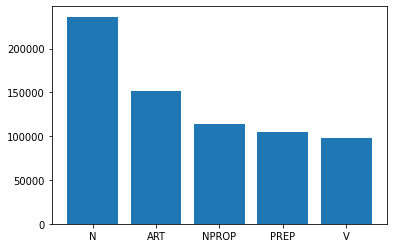

In [ ]:
plt.bar(dict(tags[:5]).keys(), dict(tags[:5]).values())

<BarContainer object of 5 artists>

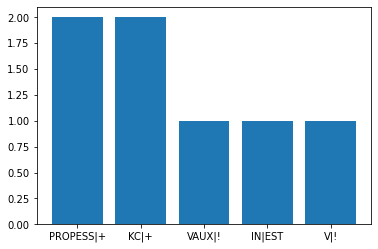

In [ ]:
plt.bar(dict(tags[-5:]).keys(), dict(tags[-5:]).values())

8) Quais são as tags mais com maior frequência? E quais com menor? Esse resultado faz sentido?

Maior frequencia: Substantivos (N), Artigos (ART), Nomes Próprios (NPROP), Preposições (PREP) e Verbos (V).

Em relação aos de menores frequencias, temos os pronomes pessoais (PROPESS), Conjução Coordenativa (KC), Verbos Auxiliare (VAUX), interjeição (IN), Verbos (V).

Por fim os dados encontrados, a relação obtida faz sentido, pois são as classificações mais utilizadas em construções de frase, resultando assim em uma maior coerência ao considerarmos a frase toda. 

---



## POS Tagging com Spacy - Desambiguando frases

Uma das aplicações do pos tagging é auxiliar na desambiguação de palavras. Uma mesma palavra pode desempenhar funções semântias diferentes, dependendo do contexto.

<b> Atividade </b>

9) Considere as frases abaixo:

9.1) frases grupo1:
```python
frase0="Ele foi andar"
frase1="O andar estava triste"
```

9.2) frase grupo2:
```python
frase2="Essa cola cola papel"
```
9.3) frases grupo3:
```python
frase3="Hora de fazer imposto de renda"
frase4="Aquilo foi imposto pelo chefe"
```

9.4) frases grupo4:
```python
frase5="Hora de fazer imposto de renda"
frase6="Aquilo foi imposto pelo chefe"
```

9.5) frases grupo5:
```python
frase7="Todo dia eu caminho"
frase8="Esse é o caminho mais fácil"
```

Utilizando o modelo ``pt_core_news_sm`` da biblioteca spacy faça as seguinte análises. Para cada token:

- a) imprima a função sintática (pos-tagging) em texto
- b) relação de dependência sintática em texto
- c) gera uma imagem das relações acims utilizando o método abaixo:
- d) análise a palavra em comum, descreva a diferença sintática encontrada e responda se é gramaticamente correta

```python
#Para imprimir detalhes
displacy.render(doc, style='dep',jupyter=True)

```

Dica: https://spacy.io/api/annotation

In [ ]:
import pt_core_news_sm
import en_core_web_sm

In [ ]:
import pandas as pd
def data_return_ab (text) :
    lista = []
    for i in range(len(text)):
        lista.append([text[i], text[i].pos_, text[i].dep_])
    return lista

<b> Atividade </b>

9.1 Frases Grupo 1

In [ ]:
txt0="Ele foi andar"
txt1="O andar estava triste"

In [ ]:
nlp = pt_core_news_sm.load()

In [ ]:
txt0_nlp = nlp(txt0)
txt1_nlp = nlp(txt1)

In [ ]:
data_return_ab(txt0_nlp)

[[Ele, 'PRON', 'nsubj:pass'],
 [foi, 'AUX', 'aux:pass'],
 [andar, 'VERB', 'ROOT']]

In [ ]:
data_return_ab(txt1_nlp)

[[O, 'DET', 'det'],
 [andar, 'NOUN', 'nsubj'],
 [estava, 'VERB', 'cop'],
 [triste, 'ADJ', 'ROOT']]

In [ ]:
#imprimir detalhes
displacy.render(txt0_nlp, style='dep',jupyter=True)

In [ ]:
#imprimir detalhes
displacy.render(txt1_nlp, style='dep',jupyter=True)

<b> d) Disucussão Grupo 1: </b>

Ambas descrições estão corretas, pois a embora "andar" seja um verbo, no sentido da frase faz referência a um lugar "o andar", se considerado o "txt1". Já no "txt0", a classificação está correta, "andar" sendo um verbo. 

<b> Atividade </b>

9.2. Frase Grupo 2

In [ ]:
txt2="Essa cola cola papel"

In [ ]:
txt2_nlp = nlp(txt2)

In [ ]:
data_return_ab(txt2_nlp)

[[Essa, 'DET', 'det'],
 [cola, 'NOUN', 'ROOT'],
 [cola, 'ADJ', 'flat:name'],
 [papel, 'PROPN', 'flat:name']]

In [ ]:
#imprimir detalhes
displacy.render(txt2_nlp, style='dep',jupyter=True)

<b> d) Disucussão Grupo 2: </b>

Acredito que as classificações a aplicação ficaram correta, pois primeiramente temos "cola" como um substantivo. Já na segunda classificação, a mesma palavra "cola" retorna um adjetivo, sendo que esse segundo é um modificador do substantivo, acrescentando uma qualidade ao mesmo. Finalmente, o que me chama a atenção é a palavra "Papel" ter sido classificado com um nome próprio, incorretamente no meu ponto de vista, pode ser que o algoritmo considerou uma palavra com letra maiúscula sendo um nome próprio e não um substantivo ou qualquer outro significado para se iniciar uma frase. 

<b> Atividade </b>

9.3. Frases Grupo 3

In [ ]:
txt3="Segundo o que me disseram, ele estava triste"
txt4="No segundo dia de trabalho ela gastou menos"

In [ ]:
txt3_nlp = nlp(txt3)
data_return_ab(txt3_nlp)

[[Segundo, 'ADP', 'case'],
 [o, 'PRON', 'obl'],
 [que, 'PRON', 'nsubj'],
 [me, 'PRON', 'iobj'],
 [disseram, 'VERB', 'acl:relcl'],
 [,, 'PUNCT', 'punct'],
 [ele, 'PRON', 'nsubj'],
 [estava, 'VERB', 'cop'],
 [triste, 'ADJ', 'ROOT']]

In [ ]:
txt4_nlp = nlp(txt4)
data_return_ab(txt4_nlp)

[[No, 'ADP', 'case'],
 [segundo, 'ADJ', 'amod'],
 [dia, 'NOUN', 'obl'],
 [de, 'ADP', 'case'],
 [trabalho, 'NOUN', 'nmod'],
 [ela, 'PRON', 'nsubj'],
 [gastou, 'VERB', 'ROOT'],
 [menos, 'ADV', 'advmod']]

In [ ]:
displacy.render(txt3_nlp, style='dep',jupyter=True)

In [ ]:
displacy.render(txt4_nlp, style='dep',jupyter=True)

<b> d) Disucussão Grupo 3: </b>

1) "Segundo o que me disseram" -> Adposição
2) "No segundo dia" -> Adjetivo

<b> Atividade </b>

9.4. Frases Grupo 4

In [ ]:
txt5="Hora de fazer imposto de renda"
txt6="Aquilo foi imposto pelo chefe"

In [ ]:
txt5_nlp = nlp(txt5)
data_return_ab(txt5_nlp)

[[Hora, 'NOUN', 'ROOT'],
 [de, 'ADP', 'mark'],
 [fazer, 'VERB', 'acl'],
 [imposto, 'NOUN', 'obj'],
 [de, 'ADP', 'case'],
 [renda, 'NOUN', 'nmod']]

In [ ]:
txt6_nlp = nlp(txt6)
data_return_ab(txt6_nlp)

[[Aquilo, 'PRON', 'nsubj:pass'],
 [foi, 'AUX', 'aux:pass'],
 [imposto, 'VERB', 'ROOT'],
 [pelo, 'ADP', 'case'],
 [chefe, 'NOUN', 'obl']]

In [ ]:
displacy.render(txt5_nlp, style='dep',jupyter=True)
displacy.render(txt6_nlp, style='dep',jupyter=True)

<b> d) Disucussão Grupo 4: </b>

Podemos observar que a palavra "imposto" aparece corretamente em ambas as frases. No primeiro momento é tratada como um substantivo e na outra frase verbo. 

<b> Atividade </b>

9.5. Frases Grupo 5

In [ ]:
txt7="Todo dia eu caminho"
txt8="Esse é o caminho mais fácil"

In [ ]:
txt7_nlp = nlp(txt7)
data_return_ab(txt7_nlp)

[[Todo, 'DET', 'det'],
 [dia, 'NOUN', 'obl'],
 [eu, 'PRON', 'nsubj'],
 [caminho, 'VERB', 'ROOT']]

In [ ]:
txt8_nlp = nlp(txt8)
data_return_ab(txt8_nlp)

[[Esse, 'PRON', 'nsubj'],
 [é, 'VERB', 'cop'],
 [o, 'DET', 'det'],
 [caminho, 'NOUN', 'ROOT'],
 [mais, 'ADV', 'advmod'],
 [fácil, 'ADJ', 'amod']]

In [ ]:
displacy.render(txt7_nlp, style='dep',jupyter=True)
displacy.render(txt8_nlp, style='dep',jupyter=True)

<b> d) Disucussão Grupo 5: </b>

A palavra "caminho" aparece corretamente nas duas frases: 
1) "Todo dia eu caminho" -> Verbo 
2) "Esse é o caminho mais fácil" -> Substantivo

<b> Esse modelo do spacy para português, em 79,94 de acurácia no pos-tagging</b>

<b> Atividade </b>

10) Sabendo que o modelo que estamos utulizando possui acurácia de 79,94 no pos-tagging, encontre um exemplo que ele falhe.

In [4]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.2.10
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.2.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.3
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
debugpy==1.0.0rc2
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.2
distributed==1.25.3
Django==3.1.1
dlib==19.18.0
dm-tree==0.1.5
docopt==0

In [ ]:
texto = "Não é que minhas frases são confusas, eu sou confuso e torno-as"

In [ ]:
texto_nlp = nlp(texto)
data_return_ab(texto_nlp)

[[Não, 'ADV', 'advmod'],
 [é, 'VERB', 'case'],
 [que, 'NOUN', 'obl'],
 [minhas, 'DET', 'det'],
 [frases, 'NOUN', 'nsubj'],
 [são, 'VERB', 'cop'],
 [confusas, 'ADJ', 'ROOT'],
 [,, 'PUNCT', 'punct'],
 [eu, 'PRON', 'nsubj'],
 [sou, 'AUX', 'cop'],
 [confuso, 'ADJ', 'parataxis'],
 [e, 'CCONJ', 'cc'],
 [torno-as, 'PROPN', 'conj']]

Acredito que a classificação na relação onde possui o "Não" ter sido classificado com um Adjetivo ficou incorreto, pois a a palavra é na verdade um substantivo masculino que expressa negação. 

# Named Entity Recognition

## Recomendação de sites

<b> Atividade </b>

11) Capture o texto de cada notícia abaixo:

- 0 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml
- 1 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml
- 2 -> https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml
- 3 -> https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml
- 4 -> https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml
- 5 -> https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml
- 6 -> https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml
- 7 -> https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml
- 8 -> https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml
- 9 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml

Para isto utilize o código abaixo:
```python
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text
```

In [1]:
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text

In [2]:
noticias = {}
noticias[0] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml'
noticias[1] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml'
noticias[2] = 'https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml'
noticias[3] = 'https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml'
noticias[4] = 'https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml'
noticias[5] = 'https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml'
noticias[6] = 'https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml'
noticias[7] = 'https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml'
noticias[8] = 'https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml'
noticias[9] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml'

In [8]:
texto_noticia = {i:get_text_url(noticias[i]) for i in noticias.keys()}

In [9]:
texto_noticia

{0: ' A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageir

<b> Atividade </b>

12) Capture as entidades de cada uma das notícias utilizando o modelo ``pt_core_news_sm`` do spacy.

<i> Dica: ents retorna as entidades de um texto </i>

In [ ]:
txt_nlp = nlp(texto_noticia[0])

In [ ]:
entidades = {i:set(list(map(str, (nlp(texto_noticia[i]).ents)))) for i in noticias.keys()}

In [ ]:
entidades

{0: {'A Secretaria Estadual de Saúde de São Paulo',
  'Adolfo Lutz',
  'COE',
  'CVE',
  'Campanha Nacional de Vacinação',
  'Centro de Contingenciamento de Emergências',
  'Centro de Vigilância Epidemiológica',
  'David Uip',
  'Helena Sato',
  'Instituto Butantan',
  'Itália',
  'José Henrique Germann',
  'Menezes',
  'Milão',
  'Ministério da Saúde',
  'OMS',
  'Organização Mundial de Saúde',
  'Paulo Menezes',
  'R$',
  'Saúde',
  'Secretaria Estadual de Saúde',
  'Secretário de Estado da Saúde',
  'São Paulo',
  'Uip',
  'estado de São Paulo'},
 1: {'Adolfo Lutz',
  'Alemanha',
  'Brasil',
  'COE',
  'Campanha Nacional de Vacinação',
  'Centro de Contingência',
  'Centro de Contingência de São Paulo',
  'Colômbia',
  'David Uip',
  'Einstein',
  'Espanha',
  'Europa',
  'G1',
  'Hospital Albert Einstein',
  'Hospital Beneficência Portuguesa',
  'Instituto Adolfo Lutz',
  'Itália',
  'João Doria',
  'Menezes',
  'Milão',
  'Ministério da Saúde',
  'OMS',
  'Organização Mundial de S

<b> Atividade </b>

13) Quais são as 5 entidades que mais apareceram nas notíciais? Critique esse resultado, ele faz sentido?

In [ ]:
lista_entidades = []

In [ ]:
for i in entidades.keys():
        lista_entidades.extend(entidades[i])

In [ ]:
Counter(lista_entidades)

Counter({'A Secretaria Estadual de Saúde de São Paulo': 1,
         'Adolfo Lutz': 3,
         'Adolfo Sachsida': 1,
         'Alemanha': 2,
         'Alerj': 1,
         'Alertas de Desastres Naturais': 1,
         'Amarela': 1,
         'Amarelo': 1,
         'Anchieta': 1,
         'Arábia Saudita': 1,
         'Assembleia Legislativa do Rio': 1,
         'Baixada Santista': 1,
         'Banco Central': 1,
         'Bolsofeios': 1,
         'Bolsonaro': 3,
         'Bota': 1,
         'Brasil': 5,
         'COE': 3,
         'CPMI': 1,
         'CVE': 1,
         'Campanha Nacional de Vacinação': 3,
         'Cemaden': 1,
         'Centro Comunitário do Caraminguava': 1,
         'Centro Nacional de Monitoramento': 1,
         'Centro de Contingenciamento de Emergências': 1,
         'Centro de Contingência': 2,
         'Centro de Contingência de São Paulo': 2,
         'Centro de Vigilância Epidemiológica': 1,
         'China': 2,
         'Colnago': 1,
         'Colômbia': 2,
   

In [ ]:
sorted(Counter(lista_entidades).items(), key=operator.itemgetter(1), reverse=True)[:5]

[('R$', 7), ('Brasil', 5), ('Itália', 4), ('São Paulo', 4), ('G1', 4)]

As 5 entidades mais recorrentes fazem sentido por causa das várias reportagens sobre o COVID. Nesta época, a situação do coronavirus na Itália estava alarmante, e a maioria das noticias são retiradas do G1 de São Paulo.

<b> Atividade </b>

14) Para a notítica 0, imprima quais foram os tipos das entidades encontradas e plote um gráfico com esses dados.
Faça uma análise desse resultado

<i> Dica: label_ retorna o nome da entidade </i>

In [ ]:
tipos_ent = (Counter([entidade.label_ for entidade in nlp(texto_noticia[0]).ents]))

In [ ]:
tipos_ent

Counter({'LOC': 10, 'MISC': 4, 'ORG': 8, 'PER': 13})

<BarContainer object of 4 artists>

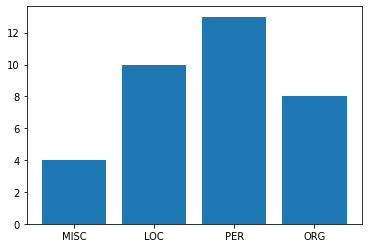

In [ ]:
plt.bar(dict(tipos_ent).keys(), dict(tipos_ent).values())

As matérias que buscamos são relacionadas ao COVID-19, identifiquemos portanto, mais entidades relacionadas a pessoas que foram vítimas desta epidemia, pessoas que estão na linha de frente ou mesmo as pessoas relacionadas a governos, orgãos internacionais e etc.. 

Podemos identificar um grande número de localidades, por se tratar de uma pandemia, mostrando as situações de cidades e países. 

Por fim, demonstra também um grande número de organizações destacadas, locais de estudos estatísticos e probabilísticos, hospitais ou pontos de apoio de médicos e enfermeiros e organizações em busca de uma vacina para conter o poder deste virus que tem muita resiliencia. 

<b> Atividade </b>

15) Plote um gráfico com esses dados com todos os tipos das entidades de todas as notícias. Compare este resultado com o resultado da notícia 0.

In [ ]:
tipos_ent = (Counter([entidade.label_ for entidade in nlp(texto_noticia[i]).ents]))

In [ ]:
todas_ent

Counter()

<BarContainer object of 4 artists>

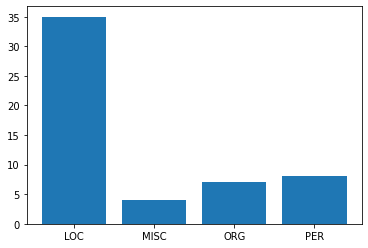

In [ ]:
plt.bar(dict(tipos_ent).keys(), dict(tipos_ent).values())

Verificando as noticias, indetificamos uma incidência muito superior na localidade, uma vez que as informações retornadas podem ou não estar relacionadas apenas a um contexto especificado.

<b> Atividade </b>

16) Imprima a notícia 0, colorindo as entidades encontradas, para isto utilize o método abaixo:

```python
displacy.render(doc, jupyter=True, style='ent')
```

<i> Dica: entidades que existem no spacy https://spacy.io/api/annotation#section-named-entities 

Caso tenha dúvida sobre alguma marcalçao use:</i>

```python
spacy.explain("MISC")
```

In [ ]:
displacy.render(nlp(texto_noticia[0]), jupyter=True, style='ent')

<b> Atividade </b>

17) Seja o documento 0 sua referência. Calcule a similaridade das entidades do documento 0 com todos outros 9. Para calcular a similaridade utilize o método jacard (implementado na aula 3). 

In [ ]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) /len(s1.union(s2))

In [ ]:
for i in range(len(entidades)):
    print(i,':' , jaccard_similarity(entidades[0],entidades[i]))

0 : 1.0
1 : 0.38636363636363635
2 : 0.034482758620689655
3 : 0.021739130434782608
4 : 0.0
5 : 0.03225806451612903
6 : 0.022727272727272728
7 : 0.023809523809523808
8 : 0.017241379310344827
9 : 0.38636363636363635


<b> Atividade </b>

18) Com os cálculos da questão anterior, responda: quais foram os três documentos com maior similaridade? Eles posssuem conteúdos semelhantes? E qual o documento com menor similaridade? Este documento faz sentido?

Os documentos com maior similaridade foram o 1 e 9. 

Os documentos 1 e 9 são iguais, por isso tem o mesmo valor. 

Todos estes 3 documentos fazem referencia a um mesmo assunto. Os demais documentos não apresentaram nenhuma similaridade, tratam de assuntos diferentes do documento 0.

## Retreino NER

Aqui nós iremos ilustrar como treinar um modelo NER no spacy

In [ ]:
nlp = pt_core_news_sm.load()

In [ ]:
# Da ruim no Colab - nlp = spacy.load("pt_core_news_sm")

In [ ]:
texto = "João nasceu em Paris em 01/01/2000"

In [ ]:
texto_nlp = nlp(texto)

In [ ]:
displacy.render(texto_nlp, style='ent',jupyter=True)

Observe que o modelo identifica <b> João </b> como pessoa e <b> Paris </b> como localidade.

Apesar do modelo ter identificado essas duas entidades ele naõ identificou a <b> data </b>.

Assim, aqui iremos mostrar como retreinar o modelo para capturar também a data.


In [ ]:
#dados de treino. Note que para cada frase, a posição de uma determinada entidade.
train_data = [
("Em 04/12/1992 nasceu Joana", {'entities':[(3, 13, "DATE"), (21,26, "PER")]}),
("Data de início: 10/01/2018", {'entities':[(16, 26, "DATE")]}),
("Maria se mudou para Paris", {'entities':[(20,26, "LOC")]}),
("Paris cidade das luzes", {'entities':[(0,5, "LOC")]}),    
("Maria nasceu em Contagem no dia 07/05/2018", {'entities':[(0,5,"PER"),(16,24,"LOC"),(32,42, "DATE")]})
]

### Retreino

- explosion/spaCy/master/examples/training/train_ner.py -> O spcay disponibiliza esse código para treinamentos.
- Mais informações? https://spacy.io/usage/training

In [ ]:
def train_spacy(data, iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('pt')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)           
    return nlp

In [ ]:
modelo_novo = train_spacy(train_data, 30)

In [ ]:
modelo_novo.to_disk("modelo_novo_NER")

<b> Atividade </b>

19) O ``modelo_novo`` já foi criado. Aplique o texto em que demonstramos que a data não foi identificada e depois imprima utilizando o ``displacy``.
O problema foi resolvido? E se mudarmos o formato da data, ele reconhce? Quais outras entidades o modelo não consegue reconhecer? 

In [ ]:
nlp_texto_novo = modelo_novo(texto)

In [ ]:
displacy.render(nlp_texto_novo, style='ent',jupyter=True)

In [ ]:
texto = "João nasceu em Paris em 01/31/2000"
nlp_texto_novo = modelo_novo(texto)
displacy.render(nlp_texto_novo, style='ent',jupyter=True)

In [ ]:
texto = "João nasceu em Paris em 01-12-2000"
nlp_texto_novo = modelo_novo(texto)
displacy.render(nlp_texto_novo, style='ent',jupyter=True)

In [ ]:
texto = "João nasceu em Paris em 2011-15-12"
nlp_texto_novo = modelo_novo(texto)
displacy.render(nlp_texto_novo, style='ent',jupyter=True)

In [ ]:
texto = "João nasceu em Paris em 2011-15-12"
nlp_texto_novo = modelo_novo(texto)
displacy.render(nlp_texto_novo, style='ent',jupyter=True)

Sim, o problema de selecionar a data foi solucionado. Apesar de colocarmos diferentes formatos de datas, ainda podemos classificalas com sucesso. Para esta amostra, o modelo conseguiu com sucesso classificar todas as entidade, vale lembrar que, por meio deste modelo não deu destaque para palavras de ação do tipo verbo, não a considerando uma entidade válida. 